<a href="https://colab.research.google.com/github/RodrigoAgronomia/workshop_esalq/blob/master/python/16_Segmentation_To_Coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.6 From semantic segmenation to coordinates

In [0]:
%%capture
!pip install livelossplot
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/workshop_esalq.git
%cd /content/workshop_esalq
!git pull
%cd /content/workshop_esalq/python

In [2]:
import os
import cv2
import time
import json
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from livelossplot import PlotLosses
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [0]:
from cnn.unet import UNet

In [0]:
#Define o mapa de cores para geração da máscara
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,0,255]
    msk[cat == 2] = [128,0,0]
    msk[cat == 3] = [255,0,0]
    msk[cat == 4] = [0,128,0]
    msk[cat == 5] = [0,255,0]
    return(msk)

In [0]:
# Diretório das imagens
im_dir = '../data/seg/img/' 
img_ext = '.JPG'

imfx = sorted(os.listdir(im_dir))
imfx = [i for i in imfx if i.endswith(img_ext)]
imfx = [os.path.join(im_dir,  imfx[i]) for i in range(len(imfx))]
imfx = np.array(imfx)


In [7]:
n_classes = 6

# Atribui o modelo
model = UNet(in_channels = 3, n_classes= n_classes, depth = 3, padding=True, up_mode='upsample')
model = model.to(device)
model.load_state_dict(torch.load('../data/model_seg_LR_best.pth', map_location=device))
model.eval()
print('Modelo OK')

Modelo OK


In [0]:
def transform(x):
    x = x.copy()
    x = x.astype('float')
    x -= 128
    x /= 35
    x = np.moveaxis(x, 2, 0)
    return(x)

In [0]:
for img_name in imfx:
    print(img_name)
    new_img_name = img_name[:-4] + '_pred.png'
    pts_name = img_name[:-4] + '_pred.csv'
    
    
    imgo = cv2.imread(img_name)
    img = transform(imgo)
    
    img_tensor = torch.from_numpy(img)
    img_variable = Variable(img_tensor.unsqueeze(0)).to(device, dtype=torch.float)

    with torch.no_grad():
        pred = model(img_variable)[0]
        
    cat = pred.argmax(0)
    class_number = 3
    predm = F.max_pool2d(pred[[class_number]], stride=1, kernel_size=25, padding=12)  
    pts = np.stack(np.where(((predm == pred[[class_number]]) * (cat == class_number)).cpu().data.numpy()))[[2, 1, 0]].transpose()

    pts[:,1] *= -1
    np.savetxt(pts_name, pts, delimiter= ',', header='lon,lat,class', comments='')
    print(len(pts))
    
    cat = cat.cpu().data.numpy()
    pred_col = colorir(cat)
    cv2.imwrite(new_img_name, pred_col)
   

        


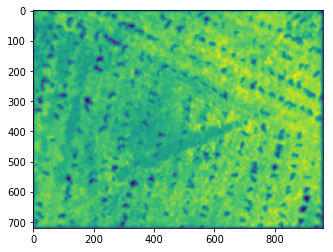

In [29]:
plt.imshow(pred.cpu()[3])

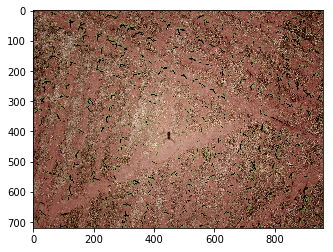

In [30]:
plt.imshow(imgo[:,:,[2,1,0]])

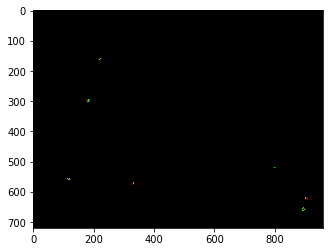

In [31]:
plt.imshow(pred_col)